In [24]:
import os
import numpy as np
import matplotlib.cm as cm
import pandas as pd
import tensorflow as tf
from PIL import Image
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
train_dir = 'imgs/train'
test_dir = 'imgs/test'
csv_file = 'driver_imgs_list.csv'

In [4]:
driver_details = pd.read_csv(csv_file)

In [5]:
driver_details

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg
...,...,...,...
22419,p081,c9,img_56936.jpg
22420,p081,c9,img_46218.jpg
22421,p081,c9,img_25946.jpg
22422,p081,c9,img_67850.jpg


In [6]:
def load_images_from_folder(base_folder, size=(112, 112)):
    total_images = sum([len(files) for r, d, files in os.walk(base_folder)])

    all_images = np.empty((total_images, size[0], size[1], 3), dtype=np.uint8)
    all_labels = np.empty(total_images, dtype=np.uint8)

    idx = 0
    for folder in os.listdir(base_folder):
        folder_path = os.path.join(base_folder, folder)

        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                img_path = os.path.join(folder_path, filename)

                try:
                    img = Image.open(img_path).resize(size)
                    all_images[idx] = np.array(img)
                    all_labels[idx] = folder[-1]
                    idx += 1
                except IOError:
                    print(f"Error in reading {img_path}. Skipping.")

    return all_images, all_labels

In [19]:
images, labels = load_images_from_folder(train_dir)

KeyboardInterrupt: 

In [8]:
images.shape

(22424, 112, 112, 3)

In [9]:
labels.shape

(22424,)

In [10]:
labels

array([7, 7, 7, ..., 2, 2, 2], dtype=uint8)

In [11]:
np.bincount(labels)

array([2489, 2267, 2317, 2346, 2326, 2312, 2325, 2002, 1911, 2129])

In [12]:
X = images.astype('float32') / 255

In [13]:
Y = to_categorical(labels, 10)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [15]:
X_train.shape, X_test.shape

((17939, 112, 112, 3), (4485, 112, 112, 3))

In [16]:
y_train.shape, y_test.shape

((17939, 10), (4485, 10))

In [17]:
np.savez_compressed(
    'data.npz',
    X_test=X_test,
    y_test=y_test,
    X_train=X_train,
    y_train=y_train
)

In [6]:
data = np.load('data.npz')
X_train, X_test, y_train, y_test = data['X_train'], data['X_test'],  data['y_train'], data['y_test'] 

In [7]:
small_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(112, 112, 3)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(10, activation='softmax')
])
small_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

2024-01-11 13:34:52.067969: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-01-11 13:34:52.067993: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-01-11 13:34:52.068005: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-01-11 13:34:52.068067: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-11 13:34:52.068349: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
small_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 110, 110, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 55, 55, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 96800)             0         
                                                                 
 dense (Dense)               (None, 10)                968010    
                                                                 
Total params: 968906 (3.70 MB)
Trainable params: 968906 (3.70 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
big_model = Sequential([
    Conv2D(32, (3, 3), activation='relu',
           input_shape=(112, 112, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])
big_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
big_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 110, 110, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 110, 110, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 55, 55, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 53, 53, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 53, 53, 64)        256       
 chNormalization)                                                
                                                      

In [9]:
history = small_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

Epoch 1/10
  1/561 [..............................] - ETA: 3:07 - loss: 2.3022 - accuracy: 0.1250

2024-01-11 13:35:06.835346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


561/561 [==============================] - 12s 20ms/step - loss: 0.5418 - accuracy: 0.8616 - val_loss: 0.0655 - val_accuracy: 0.9853
Epoch 2/10
561/561 [==============================] - 11s 19ms/step - loss: 0.0183 - accuracy: 0.9964 - val_loss: 0.0248 - val_accuracy: 0.9940
Epoch 3/10
561/561 [==============================] - 11s 19ms/step - loss: 0.0055 - accuracy: 0.9996 - val_loss: 0.0303 - val_accuracy: 0.9938
Epoch 4/10
561/561 [==============================] - 11s 19ms/step - loss: 0.0066 - accuracy: 0.9986 - val_loss: 0.0159 - val_accuracy: 0.9964
Epoch 5/10
561/561 [==============================] - 11s 19ms/step - loss: 5.2333e-04 - accuracy: 1.0000 - val_loss: 0.0150 - val_accuracy: 0.9962
Epoch 6/10
561/561 [==============================] - 11s 19ms/step - loss: 2.0376e-04 - accuracy: 1.0000 - val_loss: 0.0144 - val_accuracy: 0.9962
Epoch 7/10
561/561 [==============================] - 11s 19ms/step - loss: 1.3453e-04 - accuracy: 1.0000 - val_loss: 0.0141 - val_accuracy

In [31]:
big_history = big_model.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/25
561/561 [==============================] - 23s 34ms/step - loss: 103.4727 - accuracy: 0.3786 - val_loss: 47.8878 - val_accuracy: 0.5710
Epoch 2/25
561/561 [==============================] - 16s 28ms/step - loss: 48.5662 - accuracy: 0.7356 - val_loss: 25.0304 - val_accuracy: 0.8754
Epoch 3/25
561/561 [==============================] - 16s 28ms/step - loss: 25.1318 - accuracy: 0.8642 - val_loss: 7.8295 - val_accuracy: 0.9625
Epoch 4/25
561/561 [==============================] - 16s 28ms/step - loss: 17.5054 - accuracy: 0.9095 - val_loss: 12.1783 - val_accuracy: 0.9478
Epoch 5/25
561/561 [==============================] - 16s 28ms/step - loss: 13.3932 - accuracy: 0.9333 - val_loss: 7.3047 - val_accuracy: 0.9594
Epoch 6/25
561/561 [==============================] - 16s 28ms/step - loss: 12.5292 - accuracy: 0.9429 - val_loss: 7.6945 - val_accuracy: 0.9732
Epoch 7/25
561/561 [==============================] - 16s 28ms/step - loss: 11.4303 - accuracy: 0.9560 - val_loss: 10.2749 - v

In [10]:
y_true_train = np.argmax(y_train, axis=1)
y_true_test = np.argmax(y_test, axis=1)

In [11]:
y_pred_train_small = small_model.predict(X_train)
y_pred_test_small = small_model.predict(X_test)

y_pred_train_classes_small = np.argmax(y_pred_train_small, axis=1)
y_pred_test_classes_small = np.argmax(y_pred_test_small, axis=1)

141/141 [==============================] - 1s 5ms/step


In [32]:
print(classification_report(y_true_test, y_pred_test_classes_small, digits=4))

              precision    recall  f1-score   support

           0     0.9964    0.9964    0.9964       552
           1     1.0000    1.0000    1.0000       451
           2     0.9977    1.0000    0.9988       427
           3     0.9957    0.9978    0.9968       462
           4     0.9913    0.9978    0.9945       455
           5     1.0000    0.9913    0.9956       458
           6     1.0000    1.0000    1.0000       478
           7     1.0000    0.9972    0.9986       356
           8     0.9924    0.9899    0.9912       396
           9     0.9911    0.9933    0.9922       450

    accuracy                         0.9964      4485
   macro avg     0.9965    0.9964    0.9964      4485
weighted avg     0.9964    0.9964    0.9964      4485


In [35]:
y_pred_train_big = big_model.predict(X_train)
y_pred_test_big = big_model.predict(X_test)

y_pred_train_classes_big = np.argmax(y_pred_train_big, axis=1)
y_pred_test_classes_big = np.argmax(y_pred_test_big, axis=1)

141/141 [==============================] - 1s 9ms/step


In [36]:
print(classification_report(y_true_test, y_pred_test_classes_big, digits=4))

              precision    recall  f1-score   support

           0     0.9927    0.9909    0.9918       552
           1     0.9956    1.0000    0.9978       451
           2     1.0000    1.0000    1.0000       427
           3     0.9893    1.0000    0.9946       462
           4     0.9978    0.9978    0.9978       455
           5     0.9913    0.9913    0.9913       458
           6     0.9979    0.9979    0.9979       478
           7     1.0000    0.9944    0.9972       356
           8     0.9949    0.9848    0.9898       396
           9     0.9933    0.9933    0.9933       450

    accuracy                         0.9951      4485
   macro avg     0.9953    0.9950    0.9952      4485
weighted avg     0.9951    0.9951    0.9951      4485


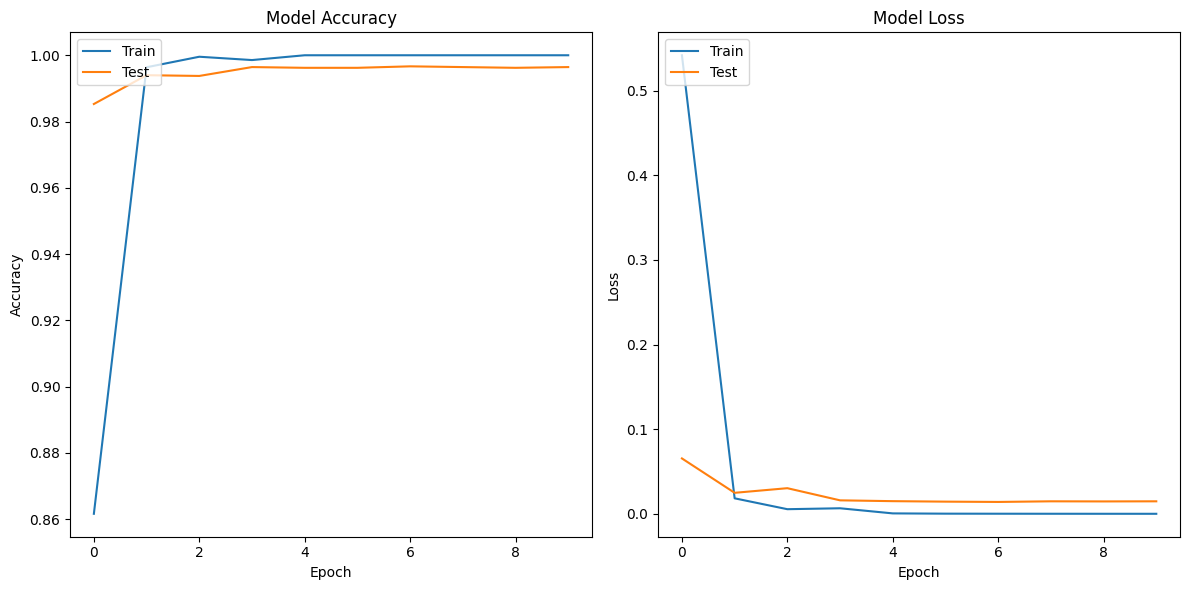

In [25]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()


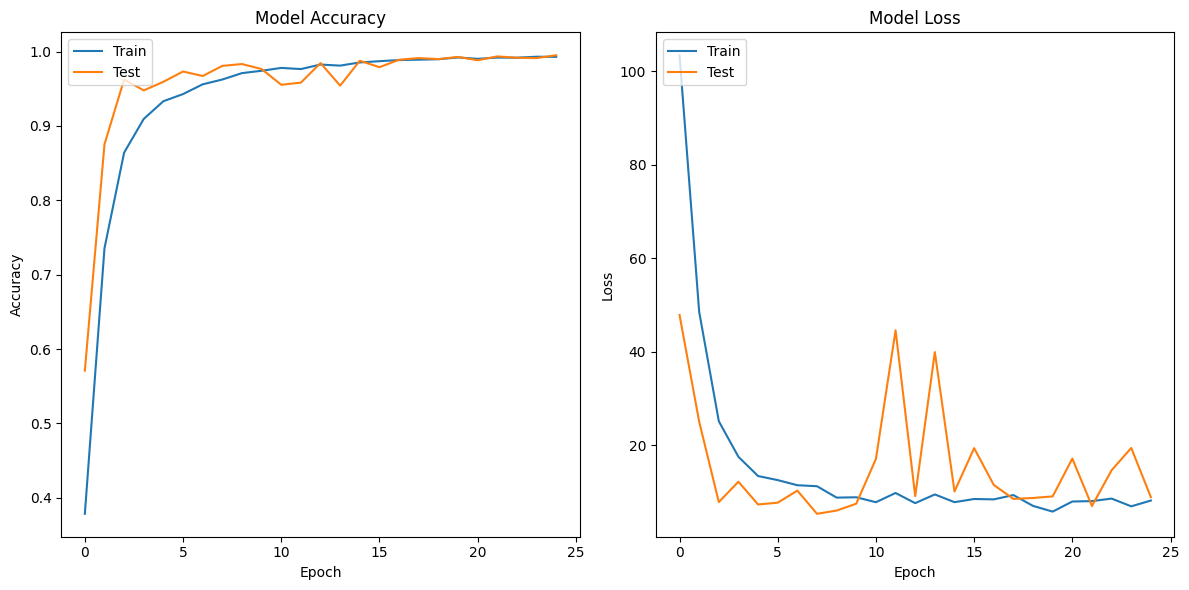

In [37]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(big_history.history['accuracy'])
plt.plot(big_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(big_history.history['loss'])
plt.plot(big_history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

In [15]:
from time import perf_counter

In [16]:
start = perf_counter()
test_loss, test_accuracy = small_model.evaluate(X_test, y_test)
print(f'test inference: {perf_counter() - start:.2f}')

141/141 [==============================] - 2s 11ms/step - loss: 0.0148 - accuracy: 0.9964
test inference: 1.72


In [38]:
start = perf_counter()
test_loss, test_accuracy = big_model.evaluate(X_test, y_test)
print(f'test inference: {perf_counter() - start:.2f}')

141/141 [==============================] - 2s 13ms/step - loss: 8.8715 - accuracy: 0.9951
test inference: 2.06


In [21]:
def get_grad_cam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [22]:
last_conv_layer_name = 'conv2d'
img_array = np.expand_dims(X_test[0], axis=0)
heatmap = get_grad_cam_heatmap(img_array, small_model, last_conv_layer_name)

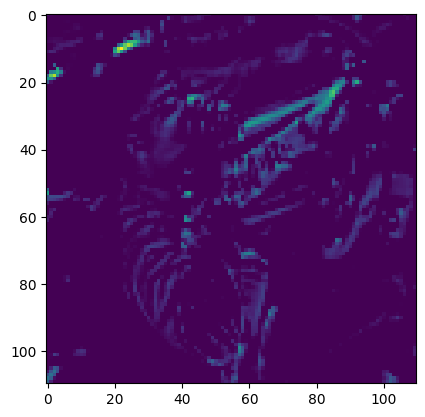

In [26]:
plt.imshow(heatmap)

In [27]:
for i, layer in enumerate(small_model.layers):
    if len(layer.get_weights()) > 0:        
        print(i, 'w', layer.get_weights()[0].shape)
        print(i, 'b', layer.get_weights()[1].shape)

0 w (3, 3, 3, 32)
0 b (32,)
3 w (96800, 10)
3 b (10,)


In [28]:
np.savez_compressed(
    'SFDDD_model.npz',
    conv_weights = small_model.layers[0].get_weights()[0],
    conv_biases = small_model.layers[0].get_weights()[1],
    dense_weights = small_model.layers[3].get_weights()[0],
    dense_biases = small_model.layers[3].get_weights()[1],
)